In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
from cleaning_functions import q_cuts,field_check,filter_split,flux_unc_val
from astropy import coordinates as coord
from forced_phot import flux_jy
from scipy.optimize import curve_fit

from scipy.signal import find_peaks, peak_prominences

sjoertpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares'

In [2]:

# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\clean_ZTF_r_batchfp_req0000338730_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aauosxv\clean_ZTF_r_batchfp_req0000338734_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aavummp\clean_ZTF_r_batchfp_req0000338750_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aajupnt\clean_ZTF_r_batchfp_req0000338755_lc.txt'
testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF19aaejtoy\clean_ZTF_r_batchfp_req0000338737_lc.txt'
ztf_name = testpath[len(sjoertpath)+1:-41]

# testfile = r'clean_ZTF_r_batchfp_req0000338730_lc.txt'
testdata = pd.read_csv(testpath,delimiter=' ')

time = testdata['time']
flux,err = flux_jy(testdata)
flux = flux.values
maxtime = time.iloc[np.argmax(flux)]
maxflux = np.max(flux)

time = time.values
t = time
print(time.shape,flux.shape,err.shape)

(493,) (493,) (493,)


In [3]:
def plot_data(filepath,name=' '):
    testdata = pd.read_csv(filepath,delimiter=' ')
    time = testdata['time']
    flux,err = flux_jy(testdata)
    flux = flux.values
    time = time.values

    plt.figure()
    plt.title(f'R band data of {name}')
    plt.scatter(time,flux,s=4,label='Data')
    plt.legend()
    plt.show()

    return flux,time

## Testing peak finders

### scipy.signal peak_finder function

In [5]:
# mean_flux = np.mean(np.abs(flux))

# peaks = find_peaks(flux,3*mean_flux,distance=50)[0]
# proms = peak_prominences(flux,peaks,wlen=100) #wlen means you check the "baseline" in a window of size wlen around each peak
#                                               #adding this improves odds that the highest prominence is the outlier

# print(peaks)
# print(proms)

# plt.figure()
# plt.scatter(t,flux,s=5)
# for idx in peaks:
#     plt.scatter(t[idx],flux[idx],c='red',marker='x',alpha=0.5)
# plt.vlines(t[np.argmax(flux)],min(flux),max(flux),linestyles='dashed',colors='black',label='argmax')
# plt.vlines(t[peaks[np.argmin(proms)]],min(flux),max(flux),linestyles='dashed',colors='orange',label='least prominence')
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("Flux")
# # plt.xlim(0,150)
# plt.show()

# def find_peak_position(flux,time,filter_outlier=False):
#     naive_peaks = find_peaks(flux,3*np.mean(np.abs(flux)),distance=10)[0]
#     if filter_outlier:
#         if len(naive_peaks) > 1: #there is a possibility of an outlier
#             proms = peak_prominences(flux,naive_peaks)[0]
#             outlier = np.argmax(proms)
#             naive_peaks = np.delete(naive_peaks,outlier)
#     return np.median(time[naive_peaks]),naive_peaks

# print(np.median(t[peaks]),np.median(t[peaks[:-1]]))

In [6]:

# flux,time = plot_data(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\clean_ZTF_r_batchfp_req0000338730_lc.txt')
# peak = find_peaks(flux,3*np.mean(np.abs(flux)),distance=10)[0]
# proms = peak_prominences(flux,peak)

In [7]:
# import matplotlib.image as mpimg

# for folder in os.listdir(sjoertpath):
#     if 'ZTF' in folder:
#         folderpath = os.path.join(sjoertpath,folder)
#         for file in os.listdir(folderpath):
#             if 'clean_ZTF_r' in file:
#                 print(50*'--')
#                 filepath = os.path.join(folderpath,file)
#                 testdata = pd.read_csv(filepath,delimiter=' ')
#                 time = testdata['time']
#                 flux,err = flux_jy(testdata)
#                 flux = flux.values
#                 time = time.values
#                 maxtime = time[np.argmax(flux)]
#                 maxflux = np.max(flux)

#                 peak_pos,possible_peaks = find_peak_position(flux,time)

#                 plt.figure()
#                 plt.title(f'R band data of {folder}')
#                 plt.scatter(time,flux,s=4,label='Data')
#                 plt.vlines(peak_pos,np.min(flux),np.max(flux),colors='black',linestyles='dashed',label='Found peak position')
#                 for p in possible_peaks:
#                     plt.scatter(time[p],flux[p],s=25,c='red',marker='x',alpha=0.5)
#                 plt.legend()
#                 plt.show()
#                 print(50*'--')


### Simple Gaussian $\chi^2$ fit

Sum of flux is now 22.44729220170769


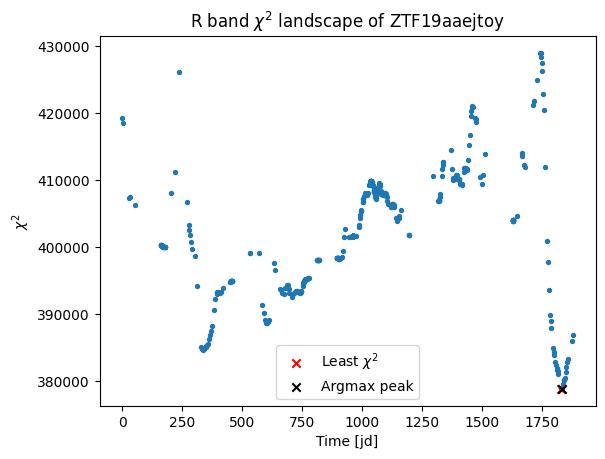

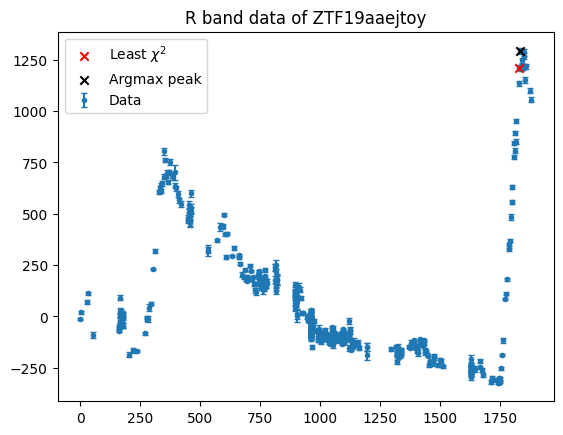

In [18]:
def chi2(flux,flux_err,time,model_fit):
    return np.sum(np.square(flux - model_fit)/np.square(flux_err))

#normalize data so that integral is 1 and amplitude need not be fitted
norm_flux = flux /np.max(flux) #/ np.sum(flux)
err_norm = err / np.max(flux) #/ np.sum(flux) #klopt als het goed is

print(f"Sum of flux is now {np.sum(norm_flux)}")

def gaussian(x,mu,amp=1,sigma=10):
    gauss = np.exp(-(np.square(x-mu)/(2*sigma**2)))
    return gauss/np.sum(gauss)

def chi2_peak_finder(flux = norm_flux,flux_err=err_norm,time=time):
    chi2_results = np.zeros(flux.shape)
    for i,t in enumerate(time):
        # fit = gaussian(flux,mu)
        chi2_results[i] = chi2(flux,flux_err,time,gaussian(time,amp=1,mu=t))
    peak = np.argmin(chi2_results)
    return chi2_results, peak

chis,peak_index = chi2_peak_finder()

plt.figure()
plt.scatter(time,chis,s=8)
mindex = peak_index
maxdex = np.argmax(norm_flux)
plt.scatter(time[mindex],chis[mindex],marker='x',c='red',zorder=10,label=r'Least $\chi^2$')
plt.scatter(time[maxdex],chis[maxdex],marker='x',c='black',zorder=10,label='Argmax peak')
# plt.yscale('log')
plt.legend()
plt.ylabel(r'$\chi^2$')
plt.xlabel('Time [jd]')
plt.title(f"R band " + r"$\chi^2$"+ f" landscape of {ztf_name}")
plt.show()

plt.figure()
plt.title(f'R band data of {ztf_name}')
plt.errorbar(time,flux,err,fmt='o',markersize=3,capsize=2,label='Data')
plt.scatter(time[mindex],flux[mindex],marker='x',c='red',zorder=10,label=r'Least $\chi^2$')
plt.scatter(time[maxdex],flux[maxdex],marker='x',c='black',zorder=10,label='Argmax peak')
plt.legend()
plt.show()
